In [8]:
!cd /data_anvar/public_datasets/preproc_study/lgg/4a_resamp/TCGA-CS-4942 && ls -l


total 81048
-rw-rw-r-- 1 1003 1005 27182242 Sep  1 10:03 CT1.nii.gz
-rw-rw-r-- 1 1003 1005    43292 Sep  1 10:03 CT1_SEG.nii.gz
-rw-rw-r-- 1 1003 1005 21026231 Sep  1 10:03 FLAIR.nii.gz
-rw-rw-r-- 1 1003 1005 14488063 Sep  1 10:03 T1.nii.gz
-rw-rw-r-- 1 1003 1005 20238893 Sep  1 10:03 T2.nii.gz


In [11]:
len(ids)

35

(230, 230, 150)
(230, 230, 150)
(230, 230, 150)
[0. 1. 2. 3.]


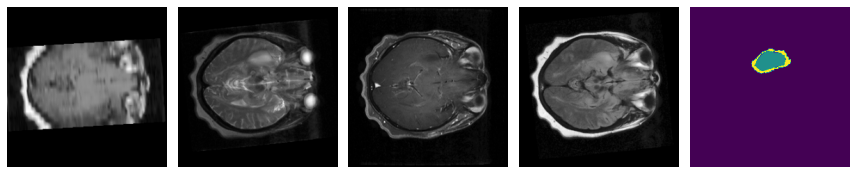

(220, 220, 150)
(220, 220, 150)
(220, 220, 150)
[0. 1. 4.]


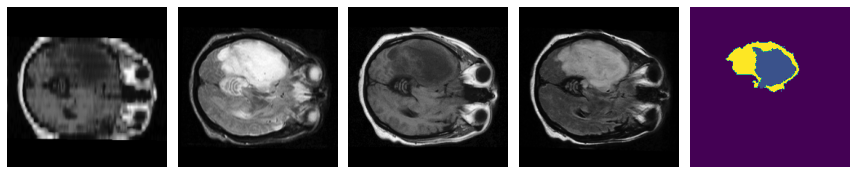

(220, 220, 150)
(220, 220, 150)
(220, 220, 150)
[0. 1. 2. 3.]


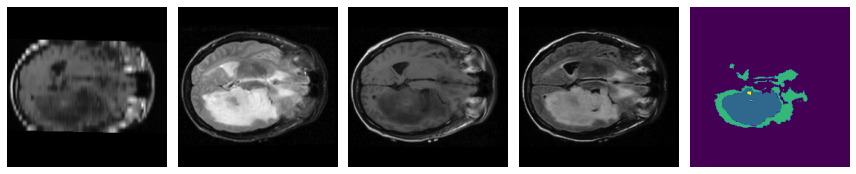

(220, 220, 180)
(220, 220, 180)
(220, 220, 180)
[0. 1. 2. 3.]


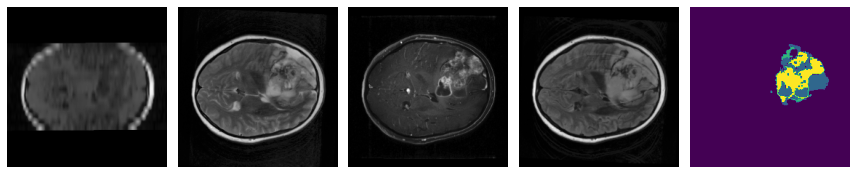

(240, 240, 180)
(240, 240, 180)
(240, 240, 180)
[0. 1. 2.]


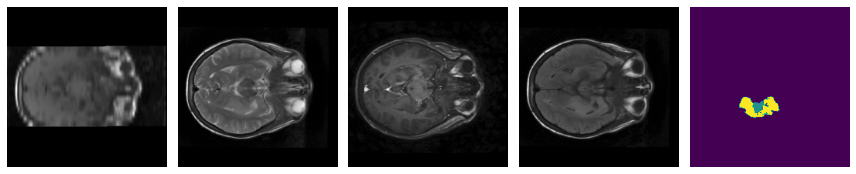

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 80
data = sorted(glob("/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/*/CT1_SEG.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-2]
#     fname = '705_18_4'
    t1 = nib.load(f"/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/{fname}/T1.nii.gz").get_fdata().astype(np.float32)
    t2 = nib.load(f"/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/{fname}/T2.nii.gz").get_fdata().astype(np.float32)
    ct1 = nib.load(f"/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/{fname}/CT1.nii.gz").get_fdata().astype(np.float32)
    flair = nib.load(f"/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/{fname}/FLAIR.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/{fname}/CT1_SEG.nii.gz").get_fdata().astype(np.float32)
    z = np.argsort(label.sum(axis=(0,1)))[-1:]
    print(label.shape), print(t1.shape), print(t2.shape)
    print(np.unique(label))
    imgs = [t1[:, :, z]]  + [t2[:, :, z]] + [ct1[:, :, z]]+ [flair[:, :, z]] + [label[:, :, z]]
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
    for i in range(5):
        if i < 4:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [198]:
import json
import os
from glob import glob
from glob2 import glob
from subprocess import call
import time
from tqdm import tqdm
import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(f'{directory}/{suffix}.nii.gz')


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["FLAIR", "T1", "CT1", "T2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
#         print(nifty.get_fdata().astype(np.int16).shape)
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d, d_out):
    sub = d.split("/")[-1]
#     sub = '705_18_4'
    print(sub)
    flair, t1, t1ce, t2 = load_channels(d, sub)
    affine, header = flair.affine, flair.header
#     print(flair.get_fdata().dtype),print(t1.get_fdata().dtype), print(t1ce.get_fdata().dtype), print(t2.get_fdata().dtype)
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#     print('l')
#     print( os.path.join(d_out, sub + ".nii.gz"))
    nibabel.save(vol, os.path.join(d_out, sub + ".nii.gz"))
#     print(glob(f'{d}/{sub}/**/MASK.nii.gz')[0])
    if os.path.exists(f'{d}/CT1_SEG.nii.gz'):
        seg = load_nifty(d, sub, "CT1_SEG")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
#         vol[vol == 4] = 3
#         mask = np.zeros(vol.shape, dtype=np.uint8)
#         mask[vol == 2] = 1
#         mask[vol == 3] = 2
#         mask[vol == 1] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#         print(os.path.join(d_out, sub + "_seg.nii.gz"))
        nibabel.save(seg, os.path.join(d_out, sub + "_seg.nii.gz"))


def prepare_dirs(d_out, train):
    img_path, lbl_path = os.path.join(d_out, "images"), os.path.join(d_out, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(d_out, "*"))
    for d in dirs:
        if '.nii.gz' in d:
                if "FLAIR" in d or "T1" in d or "CT1" in d or "T2" in d:
                    continue
                if "_seg" in d:
                    call(f"mv {d} {lbl_path}", shell=True)
                else:
                    call(f"mv {d} {img_path}", shell=True)
                
#         call(f"rm -rf {d}", shell=True)
         

def prepare_dataset_json(d_out, train):
    images, labels = glob(os.path.join(d_out, "images", "*")), glob(os.path.join(d_out, "labels", "*"))
    images = sorted([img.replace(d_out + "/", "") for img in images])
    labels = sorted([lbl.replace(d_out + "/", "") for lbl in labels])
    
    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "tumor core", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(d_out, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train, out):
    print(f"Preparing GBM dataset from: {data}")
    d_out = out
    sub_er = []
    if not os.path.exists(d_out):
        call(f"mkdir {d_out}", shell=True)
    start = time.time()
#     run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "*"))))
    for each in tqdm(sorted(glob(os.path.join(data, "*")))):
        
         print(each)
#         if each != '1743_18_4':
#             try:
#                 print(each)
         if os.path.exists(os.path.join(each, "CT1_SEG.nii.gz")):
                    prepare_nifty(each, d_out)
#             except:
#                 sub_er.append(each.split("/")[-1])
    print(sub_er)
    prepare_dirs(d_out, train)
    prepare_dataset_json(d_out, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")


In [14]:
len(os.listdir('/data_anvar/public_datasets/preproc_study/lgg/4a_resamp/'))

39

In [233]:
!cd /data/newdata/data/lgg/ && mkdir 6_hist_3_fold

In [231]:
!cd /data_anvar/public_datasets/preproc_study/lgg/6_hist && ls -l

total 32
drwxrwxr-x 40 1003 1005 4096 Sep  4 19:09 6_hist_fold_0
drwxrwxr-x 40 1003 1005 4096 Sep  4 19:15 6_hist_fold_1
drwxrwxr-x 40 1003 1005 4096 Sep  4 19:21 6_hist_fold_2
drwxrwxr-x 40 1003 1005 4096 Sep 28 12:56 6_hist_gbm
drwxrwxr-x 40 1003 1005 4096 Oct 10 18:40 6_hist_gbm_fold_0
drwxrwxr-x 40 1003 1005 4096 Oct 10 19:05 6_hist_gbm_fold_1
-rw-rw-r--  1 1003 1005 6348 Sep  4 19:28 logging.txt


In [254]:
prepare_dataset('/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/',True, '/data/newdata/data/lgg/6_hist_3_fold/lgg_6_hist_fold_2')

Preparing GBM dataset from: /data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/


  0%|                                                                        | 0/38 [00:00<?, ?it/s]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-4942
TCGA-CS-4942


  3%|█▋                                                              | 1/38 [00:02<01:41,  2.75s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-4944
TCGA-CS-4944


  5%|███▎                                                            | 2/38 [00:05<01:37,  2.71s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-5393
TCGA-CS-5393


  8%|█████                                                           | 3/38 [00:07<01:30,  2.60s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-5396
TCGA-CS-5396


 11%|██████▋                                                         | 4/38 [00:11<01:37,  2.88s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-5397
TCGA-CS-5397


 13%|████████▍                                                       | 5/38 [00:14<01:43,  3.13s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-6186
TCGA-CS-6186


 16%|██████████                                                      | 6/38 [00:18<01:46,  3.32s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-6188
TCGA-CS-6188


 18%|███████████▊                                                    | 7/38 [00:22<01:47,  3.47s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-6665
TCGA-CS-6665


 21%|█████████████▍                                                  | 8/38 [00:24<01:35,  3.19s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-6666
TCGA-CS-6666


 24%|███████████████▏                                                | 9/38 [00:28<01:37,  3.35s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-6668
TCGA-CS-6668


 26%|████████████████▌                                              | 10/38 [00:32<01:35,  3.40s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-CS-6669
TCGA-CS-6669


 29%|██████████████████▏                                            | 11/38 [00:34<01:27,  3.24s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-5851
TCGA-DU-5851


 32%|███████████████████▉                                           | 12/38 [00:40<01:41,  3.89s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-5854
TCGA-DU-5854


 34%|█████████████████████▌                                         | 13/38 [00:44<01:43,  4.12s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-5855
TCGA-DU-5855


 37%|███████████████████████▏                                       | 14/38 [00:48<01:37,  4.07s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-5872
TCGA-DU-5872


 39%|████████████████████████▊                                      | 15/38 [00:53<01:34,  4.12s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-5874
TCGA-DU-5874


 42%|██████████████████████████▌                                    | 16/38 [00:57<01:29,  4.06s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-6404
TCGA-DU-6404


 45%|████████████████████████████▏                                  | 17/38 [01:01<01:25,  4.08s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-6542
TCGA-DU-6542


 47%|█████████████████████████████▊                                 | 18/38 [01:04<01:19,  3.97s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7008
TCGA-DU-7008


 50%|███████████████████████████████▌                               | 19/38 [01:08<01:12,  3.83s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7010
TCGA-DU-7010


 53%|█████████████████████████████████▏                             | 20/38 [01:12<01:08,  3.78s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7014
TCGA-DU-7014


 55%|██████████████████████████████████▊                            | 21/38 [01:16<01:06,  3.90s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7015
TCGA-DU-7015


 58%|████████████████████████████████████▍                          | 22/38 [01:20<01:03,  3.97s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7018
TCGA-DU-7018


 61%|██████████████████████████████████████▏                        | 23/38 [01:24<00:58,  3.93s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7019
TCGA-DU-7019


 63%|███████████████████████████████████████▊                       | 24/38 [01:28<00:54,  3.92s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7294
TCGA-DU-7294


 66%|█████████████████████████████████████████▍                     | 25/38 [01:31<00:48,  3.71s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7298
TCGA-DU-7298


 68%|███████████████████████████████████████████                    | 26/38 [01:34<00:44,  3.69s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7299
TCGA-DU-7299


 71%|████████████████████████████████████████████▊                  | 27/38 [01:38<00:41,  3.75s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7300
TCGA-DU-7300


 74%|██████████████████████████████████████████████▍                | 28/38 [01:42<00:37,  3.75s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7301
TCGA-DU-7301


 76%|████████████████████████████████████████████████               | 29/38 [01:46<00:33,  3.73s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7302
TCGA-DU-7302


 79%|█████████████████████████████████████████████████▋             | 30/38 [01:50<00:30,  3.81s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7304
TCGA-DU-7304


 82%|███████████████████████████████████████████████████▍           | 31/38 [01:53<00:26,  3.73s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7306
TCGA-DU-7306


 84%|█████████████████████████████████████████████████████          | 32/38 [01:58<00:23,  3.94s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-7309
TCGA-DU-7309


 87%|██████████████████████████████████████████████████████▋        | 33/38 [02:02<00:20,  4.03s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-8162
TCGA-DU-8162


 89%|████████████████████████████████████████████████████████▎      | 34/38 [02:06<00:15,  3.94s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-8164
TCGA-DU-8164


 92%|██████████████████████████████████████████████████████████     | 35/38 [02:09<00:11,  3.89s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-8166
TCGA-DU-8166


 95%|███████████████████████████████████████████████████████████▋   | 36/38 [02:13<00:07,  3.85s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-8167
TCGA-DU-8167


 97%|█████████████████████████████████████████████████████████████▎ | 37/38 [02:17<00:03,  3.84s/it]

/data_anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm_fold_2/TCGA-DU-8168
TCGA-DU-8168


100%|███████████████████████████████████████████████████████████████| 38/38 [02:21<00:00,  3.71s/it]


[]
Preparing time: 145.47


In [217]:
!cd /data/newdata/data/lgg/6_hist_gbm/lgg_6_hist_fold_0/images && ls

TCGA-CS-4942.nii.gz  TCGA-DU-5855.nii.gz  TCGA-DU-7299.nii.gz
TCGA-CS-4944.nii.gz  TCGA-DU-5872.nii.gz  TCGA-DU-7300.nii.gz
TCGA-CS-5393.nii.gz  TCGA-DU-5874.nii.gz  TCGA-DU-7301.nii.gz
TCGA-CS-5396.nii.gz  TCGA-DU-6404.nii.gz  TCGA-DU-7302.nii.gz
TCGA-CS-5397.nii.gz  TCGA-DU-6542.nii.gz  TCGA-DU-7304.nii.gz
TCGA-CS-6186.nii.gz  TCGA-DU-7008.nii.gz  TCGA-DU-7306.nii.gz
TCGA-CS-6188.nii.gz  TCGA-DU-7010.nii.gz  TCGA-DU-7309.nii.gz
TCGA-CS-6665.nii.gz  TCGA-DU-7014.nii.gz  TCGA-DU-8162.nii.gz
TCGA-CS-6666.nii.gz  TCGA-DU-7015.nii.gz  TCGA-DU-8164.nii.gz
TCGA-CS-6668.nii.gz  TCGA-DU-7018.nii.gz  TCGA-DU-8166.nii.gz
TCGA-CS-6669.nii.gz  TCGA-DU-7019.nii.gz  TCGA-DU-8167.nii.gz
TCGA-DU-5851.nii.gz  TCGA-DU-7294.nii.gz  TCGA-DU-8168.nii.gz
TCGA-DU-5854.nii.gz  TCGA-DU-7298.nii.gz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 80
data = sorted(glob("/data/newdata/data/lgg/6_hist_gbm/lgg_6_hist_fold_0/images/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-2]
#     fname = '705_18_4'
    t1 = nib.load(f"/data/newdata/data/lgg/6_hist_gbm/lgg_6_hist_fold_0/images/{fname}юnii.gz").get_fdata().astype(np.float32)
    labels = nib.load(f"/data/newdata/data/lgg/6_hist_gbm/lgg_6_hist_fold_0/labels/{fname}юnii.gz").get_fdata().astype(np.float32)
    z = np.argsort(label.sum(axis=(0,1)))[-1:]
    print(label.shape), print(t1.shape), print(t2.shape)
    print(np.unique(label))
    imgs = [t1[:, :, z]]  + [t2[:, :, z]] + [ct1[:, :, z]]+ [flair[:, :, z]] + [label[:, :, z]]
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
    for i in range(5):
        if i < 4:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [180]:
!python3 ../preprocess.py --data /data/newdata/data/lgg --task 64 --ohe --exec_mode training --results /data/newdata/data/lgg/

Preprocessing /data/newdata/data/lgg/lgg_5_ss_shared
run_parralel)
training
Pre-processing time: 10.75


In [33]:
# 4a_resamp

Metrics


In [59]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

In [60]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data,mat_fie_sub, path_to_orig, path_to_resampled, mod = None):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
#         print('data')
#         print(data.shape)
        old_orig = ants.image_read(path_to_resampled)
#         print('old_orig')
#         print(old_orig.shape)
        
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        if mod == '3a_atlas':
#             print('a')
            new_img = ants.apply_transforms(new_orig, old_like, whichtoinvert=[True],
                                      transformlist = mat_fie_sub)
        elif mod == '2a_interp':
#             print('cehck')
            new_img = ants.resample_image(old_like, new_orig.shape, True, 0)
        else:
            new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
#         print('new_img')
#         print(new_img.shape)
        output_file = new_img.numpy().astype('float16')
#         print(new_orig.shape)
#         print(output_file.shape)
#         print(new_orig.shape)
        if (new_orig.shape[0]-output_file.shape[0] < 0 ) or (new_orig.shape[1]-output_file.shape[1] < 0) or (new_orig.shape[2]-output_file.shape[2] < 0):
            print('1')
            output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
        if (new_orig.shape[0]-output_file.shape[0] > 0) or (new_orig.shape[1]-output_file.shape[1] > 0) or (new_orig.shape[2]-output_file.shape[2] > 0):
            print('2')
            output_file = np.pad(output_file, ((0, new_orig.shape[0]-output_file.shape[0]), (0, new_orig.shape[1]-output_file.shape[1]), (0, new_orig.shape[2]-output_file.shape[2])), 'constant', constant_values=0)

#         output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
#         print(output_file.shape)
#         print(output_file.shape)
        return (output_file)
    
def pred_invert_resample_classes(data, mat_file_path, path_to_orig, path_to_resampled, mod):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')
#         print(data.shape)
        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)
    
#         print(old_orig_ct1.shape)
#         print(new_orig_ct1.shape)
        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])
#         print('old_like')
# #         print(old_like_ch_2.shape)
        if mod == '2a_interp':
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.shape, True, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.shape, True, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.shape, True, 0)
        if mod == '3a_atlas':
            new_img_0 = ants.apply_transforms(new_orig_ct1, old_like_ch_0, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_1 = ants.apply_transforms(new_orig_ct1, old_like_ch_1, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_2 = ants.apply_transforms(new_orig_ct1, old_like_ch_2, whichtoinvert=[True],
                                          transformlist = mat_file_path)
        else:
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.spacing, False, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.spacing, False, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.spacing, False, 0)
       
        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.astype('float16')
#         print(output_file.shape)
#         print('check_shape')
#         print(new_orig_ct1.shape)
#         print(new_orig_ct1.shape[2]-output_file.shape[3])
#         print((new_orig_ct1.shape[1]-output_file.shape[2]))
#         print((new_orig_ct1.shape[0]-output_file.shape[1]))
        if (new_orig_ct1.shape[2]-output_file.shape[3] < 0 ) or (new_orig_ct1.shape[1]-output_file.shape[2] < 0) or (new_orig_ct1.shape[0]-output_file.shape[1] < 0):
            print(1)
            output_file = output_file[:, :new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
            
        if (new_orig_ct1.shape[2]-output_file.shape[3] > 0) or (new_orig_ct1.shape[1]-output_file.shape[2] > 0 ) or (new_orig_ct1.shape[0]-output_file.shape[1] > 0):
            print(2)
            output_file = np.pad(output_file, ((0,0), (0, new_orig_ct1.shape[0]-output_file.shape[1]), (0, new_orig_ct1.shape[1]-output_file.shape[2]), (0, new_orig_ct1.shape[2]-output_file.shape[3])), 'constant', constant_values=0)

        output_file = output_file[:,:new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
#         print(output_file.shape)
        
        return (output_file)

In [61]:
def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)

In [62]:
def calculate_metrics_brats_1cl(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1',
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    return df

def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_3'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_3'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_3'] = sens
    df.at[0,'Precision_3'] = precision
    df.at[0,'Specificity_3'] = spec
    return df

In [63]:
    
def calculate_metrics(subjects, path_to_file, path_to_orig, path_to_pred, path_to_resamp, path_to_target, dataset, out = '/home/polina/glioma/all_dice_metrics.csv', mod=None  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
#     _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
#                 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
#                 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
#                'Specificity_1', 'Specificity_2', 'Specificity_3',
#                'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
#                'Precision_1', 'Precision_2', 'Precision_3']
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    orig_folder = Path(path_to_orig)
    resamp_folder = Path(path_to_resamp)
    target_folder = Path(path_to_target)
    file_folder = Path(path_to_file)
    for ids in tqdm(subjects):
        print(ids)
        pred_sub = os.path.join(pred_folder, ids + '.npy.npz')
        orig_sub = os.path.join(orig_folder, ids,'CT1_SEG.nii.gz')
        resamp_sub = os.path.join(resamp_folder, ids,'CT1_SEG.nii.gz')
        mat_fie_sub = os.path.join(file_folder, ids,'T1C_to_SRI_fwd.mat')
#         targets = nib.load(os.path.join(target_folder, ids + '_seg.nii.gz'))
#         targets = ants.image_read(orig_sub)
#         targets = ants.reorient_image2(label_orig, orientation = 'LAI')
#         targets = nib.load(orig_sub)
#         spaces = targets.header.get_zooms()
#         spaces = targets.spacing
#         targets = targets.numpy().astype('int')
        targets = ants.image_read(f'{target_folder}/{ids}/CT1_SEG.nii.gz')
        spaces = targets.spacing
#         targets = ants.reorient_image2(targets, orientation = 'LAI').numpy()
        targets = targets.numpy()
#         print(targets.shape)
#         print(np.unique(targets))
        data = np.load(pred_sub, allow_pickle=True)['arr_0']
#         print(data.shape)
        if np.shape(data)[0] == 1: 
#             print('check')
#             print(ants.image_read(orig_sub).shape)
#             print(targets.shape)
            prediction = pred_invert_resample_1cl(data, mat_fie_sub, orig_sub, resamp_sub, mod)
            prediction = np.round(prediction, 0)
#         pred = np.transpose(pred, (0, 3, 2, 1))
#             print(prediction.shape)
#             print(np.unique(prediction))
#             print(targets.shape)
#             print(prediction.shape)
            df = calculate_metrics_brats_1cl(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             print(df)
        elif np.shape(data)[0] > 1: 
            prediction = pred_invert_resample_classes(data, mat_fie_sub, orig_sub, resamp_sub, mod)
#             prediction = data.transpose(0,3,2,1).astype('float32')
            prediction = np.round(prediction, 0)
            y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
            targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
#             print(targets.shape)
#             print(prediction.shape)
            df=calculate_metrics_brats(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             except:
#                 continue
        os.makedirs(os.path.join(out, dataset,ids), exist_ok = True)
#         print(path_to_pred)
#         out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('best_')[-1].replace('=', '_') + '.json')
        out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('predictions_')[-1].replace('=', '_') + '.json')
       #         df.to_json(out_path, orient='records')
        sub_dict = {dataset : {path_to_pred.split('/')[-2]: {path_to_pred.split('_')[-2]: {}}}}
        sub_dict[dataset][path_to_pred.split('/')[-2]][path_to_pred.split('_')[-2]] = df.to_dict('records')[0]
#         print(sub_dict)
        with open(out_path, 'w') as fp:
            json.dump(sub_dict, fp)
#         print(df)
        af_all = af_all.append(df)
#     af_all.to_csv(out)  
    print(af_all.mean())
    print(len(af_all))
    return af_all

In [117]:
len(os.listdir('/data/newdata/bgpd_infer/bgpd_2a_interp/predictions_best_epoch=101-dice_mean=77_26_task=52_fold=1_tta'))

180

In [75]:
!cd /data/newdata/lgg_results/lgg_2a_interp_from_gbm_TL/fold-0/checkpoints && ls

In [302]:
! cd /data/newdata/lgg_infer/lgg_6_hist_fold_2 && ls -l

total 4
drwxr-xr-x 2 root root 4096 Oct 20 22:31 'predictions_best_epoch=23-dice_mean=43_67_task=63_fold=2_tta'


In [303]:
orig_folder = '/data_anvar/public_datasets/preproc_study/lgg/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/lgg/4a_resamp'
file = '/data_anvar/public_datasets/preproc_study/lgg/3a_atlas'
pred_folder = '/data/newdata/lgg_infer/lgg_6_hist_fold_2/predictions_best_epoch=23-dice_mean=43_67_task=63_fold=2_tta'
target_folder = '/data_anvar/public_datasets/preproc_study/lgg/1_reg'
reg_1 = '/data_anvar/public_datasets/preproc_study/lgg/1_reg'
out_json = '/results/metrics'
dataset = 'lgg'
# TCGA-76-4932
subjects = [each[:-8] for each in os.listdir(pred_folder) if each[:-8]!= '1743_18_4']
print(len(subjects))
assert(len(subjects) == 38)
# subjects = ['1257_18']
met = calculate_metrics(subjects, file, reg_1, pred_folder, resample_folder, target_folder, dataset, out = out_json)

38


  0%|                                                                        | 0/38 [00:00<?, ?it/s]

TCGA-DU-7302


/tmp/ipykernel_3888/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  3%|█▋                                                              | 1/38 [00:16<10:21, 16.80s/it]

TCGA-DU-7304


  5%|███▎                                                            | 2/38 [00:29<08:41, 14.49s/it]

TCGA-CS-4944


  8%|█████                                                           | 3/38 [00:33<05:28,  9.40s/it]

TCGA-DU-5854


 11%|██████▋                                                         | 4/38 [00:37<04:19,  7.64s/it]

TCGA-CS-6669


 13%|████████▍                                                       | 5/38 [00:41<03:26,  6.26s/it]

TCGA-CS-4942


 16%|██████████                                                      | 6/38 [00:44<02:46,  5.22s/it]

TCGA-DU-7008


 18%|███████████▊                                                    | 7/38 [00:49<02:36,  5.03s/it]

TCGA-DU-6404


 21%|█████████████▍                                                  | 8/38 [00:54<02:29,  5.00s/it]

TCGA-CS-5397


 24%|███████████████▏                                                | 9/38 [01:02<02:53,  5.99s/it]

TCGA-DU-7306


 26%|████████████████▌                                              | 10/38 [01:18<04:12,  9.02s/it]

TCGA-DU-7294


 29%|██████████████████▏                                            | 11/38 [01:31<04:34, 10.18s/it]

TCGA-DU-7301


 32%|███████████████████▉                                           | 12/38 [01:45<04:52, 11.25s/it]

TCGA-CS-6665


 34%|█████████████████████▌                                         | 13/38 [01:48<03:40,  8.81s/it]

TCGA-DU-7299


 37%|███████████████████████▏                                       | 14/38 [02:02<04:13, 10.56s/it]

TCGA-DU-7309


 39%|████████████████████████▊                                      | 15/38 [02:18<04:35, 11.96s/it]

TCGA-DU-7015


 42%|██████████████████████████▌                                    | 16/38 [02:33<04:46, 13.00s/it]

TCGA-DU-6542


 45%|████████████████████████████▏                                  | 17/38 [02:48<04:45, 13.61s/it]

TCGA-DU-5872


 47%|█████████████████████████████▊                                 | 18/38 [02:53<03:42, 11.14s/it]

TCGA-CS-6188


 50%|███████████████████████████████▌                               | 19/38 [03:07<03:48, 12.03s/it]

TCGA-DU-7014


 53%|█████████████████████████████████▏                             | 20/38 [03:14<03:06, 10.35s/it]

TCGA-DU-7019


 55%|██████████████████████████████████▊                            | 21/38 [03:29<03:19, 11.73s/it]

TCGA-CS-5393


 58%|████████████████████████████████████▍                          | 22/38 [03:31<02:23,  8.99s/it]

TCGA-DU-7018


 61%|██████████████████████████████████████▏                        | 23/38 [03:46<02:40, 10.68s/it]

TCGA-DU-8168


 63%|███████████████████████████████████████▊                       | 24/38 [04:01<02:46, 11.87s/it]

TCGA-DU-5851


 66%|█████████████████████████████████████████▍                     | 25/38 [04:06<02:10, 10.02s/it]

TCGA-DU-7298


 68%|███████████████████████████████████████████                    | 26/38 [04:11<01:41,  8.42s/it]

TCGA-DU-5855


 71%|████████████████████████████████████████████▊                  | 27/38 [04:51<03:14, 17.72s/it]

TCGA-CS-6186


 74%|██████████████████████████████████████████████▍                | 28/38 [04:57<02:24, 14.45s/it]

TCGA-DU-8162


 76%|████████████████████████████████████████████████               | 29/38 [05:10<02:04, 13.88s/it]

TCGA-DU-8164


 79%|█████████████████████████████████████████████████▋             | 30/38 [05:23<01:48, 13.53s/it]

TCGA-DU-8167


 82%|███████████████████████████████████████████████████▍           | 31/38 [05:36<01:33, 13.33s/it]

TCGA-DU-7300


 84%|█████████████████████████████████████████████████████          | 32/38 [05:49<01:19, 13.25s/it]

TCGA-CS-5396


 87%|██████████████████████████████████████████████████████▋        | 33/38 [05:52<00:51, 10.39s/it]

TCGA-DU-8166


 89%|████████████████████████████████████████████████████████▎      | 34/38 [06:06<00:45, 11.34s/it]

TCGA-DU-7010


 92%|██████████████████████████████████████████████████████████     | 35/38 [06:11<00:28,  9.48s/it]

TCGA-CS-6668


 95%|███████████████████████████████████████████████████████████▋   | 36/38 [06:23<00:20, 10.27s/it]

TCGA-DU-5874


 97%|█████████████████████████████████████████████████████████████▎ | 37/38 [06:36<00:11, 11.17s/it]

TCGA-CS-6666


100%|███████████████████████████████████████████████████████████████| 38/38 [06:49<00:00, 10.78s/it]

Dice_1             0.625592
Dice_2             0.496237
Dice_3             0.000000
Hausdorff95_1     69.911684
Hausdorff95_2     66.339658
Hausdorff95_3           inf
Sensitivity_1      0.677981
Sensitivity_2      0.676549
Sensitivity_3      0.000000
Specificity_1      0.995367
Specificity_2      0.995798
Specificity_3      1.000000
Surface_dice_1     0.319116
Surface_dice_2     0.235005
Surface_dice_3     0.000000
Precision_1        0.628722
Precision_2        0.450499
Precision_3             NaN
dtype: float64
38


In [184]:
!cd /data/newdata/lgg_infer/lgg_6_hist_fold_0_from_gbm_infer/predictions_best_epoch=249-dice_mean=73_16_lgg_task=31.0_fold=0_tta && ls

TCGA-CS-4942.npy.npz


In [148]:
!cd /results/bgpd_results/bgpd_4a_resamp/fold-0/checkpoints && ls -l

total 2979480
-rw-r--r-- 1 root root 610191601 Jul  7 22:41 'best_epoch=91-dice_mean=72.27.ckpt'
-rw-r--r-- 1 root root 610191601 Jul  7 22:39 'epoch=90-dice_mean=72.26.ckpt'
-rw-r--r-- 1 root root 610191601 Jul  7 22:41 'epoch=91-dice_mean=72.27.ckpt'
-rw-r--r-- 1 root root 610191855 Jul  7 22:44 'epoch=92-dice_mean=72.21.ckpt'
-rw-r--r-- 1 root root 610191855 Jul  7 23:01  last.ckpt


In [204]:
out_json = '/results/metrics/bgpd/'
dataset = 'bgpd'
task = 'bgpd_4a_resamp_300'
fold = 'fold_2'
_columns = ['Ids','Dice_1', 
                'Hausdorff95_1', 
                'Sensitivity_1',
               'Specificity_1', 
               'Surface_dice_1',
               'Precision_1']
metrics_all = pd.DataFrame(columns = _columns)
for i,sub in tqdm((enumerate(os.listdir(out_json)))):
    for sub_t in os.listdir(os.path.join(out_json, sub)):
        if f'{task}_epoch' in sub_t:
            if fold in sub_t:
#                 print(i)
#                 print(os.path.join(out_json, sub, sub_t))
                metrics = json.load(open(os.path.join(out_json, sub, sub_t)))
#                 print(metrics)
                metrics = metrics[dataset][task][fold.replace('_', '=')]
                for each in metrics:
                    if each != 'Dice_1Hausdorff95_1':
                        metrics_all[each]
                        metrics_all.at[i,'Ids'] = sub
                        metrics_all.at[i,'Dice_1'] = metrics['Dice_1']   
                        metrics_all.at[i,'Hausdorff95_1'] = metrics['Hausdorff95_1']
                        metrics_all.at[i,'Sensitivity_1'] = metrics['Sensitivity_1']
                        metrics_all.at[i,'Specificity_1'] = metrics['Specificity_1']
                        metrics_all.at[i,'Surface_dice_1'] = metrics['Surface_dice_1']
                        metrics_all.at[i,'Precision_1'] = metrics['Precision_1']
                    
print(len(metrics_all))
print(metrics_all.mean())
print(metrics_all.std())

179it [00:00, 446.93it/s]


179
Dice_1            0.763548
Hausdorff95_1          inf
Sensitivity_1     0.779873
Specificity_1     0.998296
Surface_dice_1    0.450993
Precision_1       0.801491
dtype: float64
Dice_1            0.162572
Hausdorff95_1          NaN
Sensitivity_1     0.194678
Specificity_1     0.002468
Surface_dice_1    0.173310
Precision_1       0.166093
dtype: float64


In [62]:
!cd /data/newdata/gbm_results/gbm_2a_interp_300/fold-0/checkpoints/ && ls

'best_epoch=215-dice_mean=77.47.ckpt'


In [204]:
! cd /data_anvar/public_datasets/preproc_study/lgg/4a_resamp && ls

TCGA-CS-4942  TCGA-CS-6666  TCGA-DU-6404  TCGA-DU-7294	TCGA-DU-7309
TCGA-CS-4944  TCGA-CS-6668  TCGA-DU-6542  TCGA-DU-7298	TCGA-DU-8162
TCGA-CS-5393  TCGA-CS-6669  TCGA-DU-7008  TCGA-DU-7299	TCGA-DU-8164
TCGA-CS-5396  TCGA-DU-5851  TCGA-DU-7010  TCGA-DU-7300	TCGA-DU-8166
TCGA-CS-5397  TCGA-DU-5854  TCGA-DU-7014  TCGA-DU-7301	TCGA-DU-8167
TCGA-CS-6186  TCGA-DU-5855  TCGA-DU-7015  TCGA-DU-7302	TCGA-DU-8168
TCGA-CS-6188  TCGA-DU-5872  TCGA-DU-7018  TCGA-DU-7304	logging.txt
TCGA-CS-6665  TCGA-DU-5874  TCGA-DU-7019  TCGA-DU-7306


(256, 256, 118)
[82]
(3, 177, 240, 240)
(256, 256, 118, 3)
(256, 256, 118, 1)
[0 1]
(256, 256, 118, 3)
[0 1]


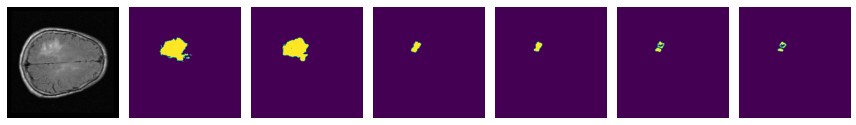

TCGA-CS-6186
dice WT
0.883937884559039
Dice_2
0.75
Dice_3
0.7845050215208035


In [209]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'TCGA-CS-6186'

orig_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/1_reg'), fname,'CT1_SEG.nii.gz')
resamp_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/4a_resamp'), fname,'CT1_SEG.nii.gz')

targets = ants.image_read(orig_sub)
targets = targets.numpy()
print(targets.shape)
l = np.argsort(targets.sum(axis=(0,1)))[-1:]
print(l)
y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)



img_orig = ants.image_read(os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/1_reg'), fname,'FLAIR.nii.gz'))
img_orig = img_orig.numpy()[:,:,:,np.newaxis]


pred = np.load(f'/data/newdata/lgg_infer/lgg_4a_resamp_from_gbm_infer/predictions_best_epoch=197-dice_mean=78_14_task=38_fold=0_tta/{fname}.npy.npz')['arr_0']
print(pred.shape)
prediction = pred_invert_resample_classes(pred, 'mat_fie_sub', orig_sub, resamp_sub, mod=None)
p = np.round(prediction, 0).transpose(1,2,3,0).astype(np.uint8)
# p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:,:,l,0]] + [label_orig[:,:,l,0]]  +[p[:,:,l,0]] +[label_orig[:,:,l,1]] +  [p[:,:,l,1]]+ [label_orig[:,:,l,2]] +[p[:,:,l,2]]
 
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
for i in range(7):
        if i < 1:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

print(fname)
print('dice WT')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (p[:,:,:,0]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (check[:,:,:,0]==1)))
print('Dice_2')
print(metrics.
      compute_dice_coefficient((label_orig[:,:,:,1]==1), (p[:,:,:,1]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,1]==1), (check[:,:,:,1]==1)))
print('Dice_3')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (p[:,:,:,2]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (check[:,:,:,2]==1)))

(512, 512, 71)
[32]
(3, 178, 240, 240)
(512, 512, 71, 3)
(512, 512, 71, 1)
[0 1]
(512, 512, 71, 3)
[0]


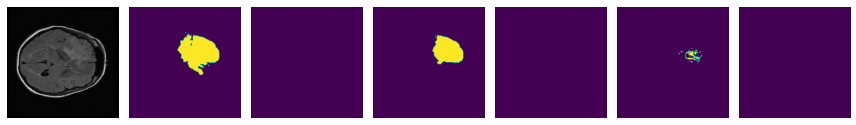

TCGA-DU-8168
dice WT
0.0
Dice_2
0.0
Dice_3
0.0


In [213]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'TCGA-DU-8168'

orig_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/1_reg'), fname,'CT1_SEG.nii.gz')
resamp_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/4a_resamp'), fname,'CT1_SEG.nii.gz')

targets = ants.image_read(orig_sub)
targets = targets.numpy()
print(targets.shape)
l = np.argsort(targets.sum(axis=(0,1)))[-1:]
print(l)
y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)



img_orig = ants.image_read(os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/1_reg'), fname,'FLAIR.nii.gz'))
img_orig = img_orig.numpy()[:,:,:,np.newaxis]


pred = np.load(f'/data/newdata/lgg_infer/lgg_6_hist_fold_0_infer_new/predictions_best_epoch=249-dice_mean=73_16_lgg_task=31.0_fold=0_tta/{fname}.npy.npz')['arr_0']
print(pred.shape)
prediction = pred_invert_resample_classes(pred, 'mat_fie_sub', orig_sub, resamp_sub, mod=None)
p = np.round(prediction, 0).transpose(1,2,3,0).astype(np.uint8)
# p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:,:,l,0]] + [label_orig[:,:,l,0]]  +[p[:,:,l,0]] +[label_orig[:,:,l,1]] +  [p[:,:,l,1]]+ [label_orig[:,:,l,2]] +[p[:,:,l,2]]
 
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
for i in range(7):
        if i < 1:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

print(fname)
print('dice WT')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (p[:,:,:,0]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (check[:,:,:,0]==1)))
print('Dice_2')
print(metrics.
      compute_dice_coefficient((label_orig[:,:,:,1]==1), (p[:,:,:,1]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,1]==1), (check[:,:,:,1]==1)))
print('Dice_3')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (p[:,:,:,2]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (check[:,:,:,2]==1)))

(1.0, 1.0, 1.0)
[123]


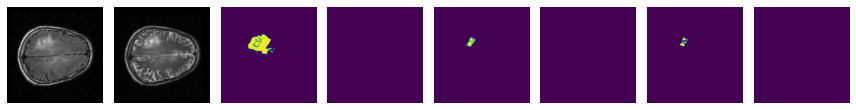

TCGA-CS-6186
dice WT
0.0
Dice_2
0.0
Dice_3
0.0


In [221]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'TCGA-CS-6186'
img_orig = nib.load(f"/data/newdata/data/lgg/6_hist_gbm/lgg_6_hist_fold_0/images/{fname}.nii.gz").get_fdata()
label_orig = nib.load(f"/data/newdata/data/lgg/6_hist_gbm/lgg_6_hist_fold_0/labels/{fname}_seg.nii.gz")
spaces = label_orig.header.get_zooms()
print(spaces)
label_orig = label_orig.get_fdata().astype(np.uint8)
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
# label_orig = ants.reorient_image2(ants.from_numpy(label_orig), orientation = 'LAS').numpy() 
y_wt, y_tc, y_et = label_orig > 0, ((label_orig == 1) + (label_orig == 3)) > 0, label_orig == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)
print(l)
pred = np.load(f'/data/newdata/lgg_infer/lgg_6_hist_fold_0_infer_new/predictions_best_epoch=249-dice_mean=73_16_lgg_task=31.0_fold=0_tta/{fname}.npy.npz')['arr_0']
p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)

imgs = [img_orig[:, :, l, i] for i in [0,3]] + [label_orig[:,:,l,0]] +[p[:,:,l,0]] +[label_orig[:,:,l,1]] + [p[:,:,l,1]]+ [label_orig[:,:,l,2]] + [p[:,:,l,2]]
 
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(12, 12))
for i in range(8):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

print(fname)
print('dice WT')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (p[:,:,:,0]==1)))
print('Dice_2')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,1]==1), (p[:,:,:,1]==1)))
print('Dice_3')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (p[:,:,:,2]==1)))

(256, 256, 118)
[82]
(3, 177, 240, 240)
(256, 256, 118, 3)
(256, 256, 118, 1)
[0 1]
(256, 256, 118, 3)
[0 1]


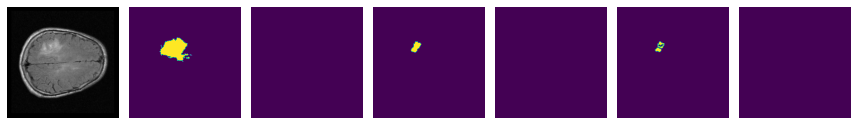

TCGA-CS-6186
dice WT
0.0
Dice_2
0.0
Dice_3
0.0


In [214]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'TCGA-CS-6186'

orig_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/1_reg'), fname,'CT1_SEG.nii.gz')
resamp_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/4a_resamp'), fname,'CT1_SEG.nii.gz')

targets = ants.image_read(orig_sub)
targets = targets.numpy()
print(targets.shape)
l = np.argsort(targets.sum(axis=(0,1)))[-1:]
print(l)
y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)



img_orig = ants.image_read(os.path.join(Path('/data_anvar/public_datasets/preproc_study/lgg/1_reg'), fname,'FLAIR.nii.gz'))
img_orig = img_orig.numpy()[:,:,:,np.newaxis]


pred = np.load(f'/data/newdata/lgg_infer/lgg_6_hist_fold_0_infer_new/predictions_best_epoch=249-dice_mean=73_16_lgg_task=31.0_fold=0_tta/{fname}.npy.npz')['arr_0']
print(pred.shape)
prediction = pred_invert_resample_classes(pred, 'mat_fie_sub', orig_sub, resamp_sub, mod=None)
p = np.round(prediction, 0).transpose(1,2,3,0).astype(np.uint8)
# p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:,:,l,0]] + [label_orig[:,:,l,0]]  +[p[:,:,l,0]] +[label_orig[:,:,l,1]] +  [p[:,:,l,1]]+ [label_orig[:,:,l,2]] +[p[:,:,l,2]]
 
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
for i in range(7):
        if i < 1:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

print(fname)
print('dice WT')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (p[:,:,:,0]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (check[:,:,:,0]==1)))
print('Dice_2')
print(metrics.
      compute_dice_coefficient((label_orig[:,:,:,1]==1), (p[:,:,:,1]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,1]==1), (check[:,:,:,1]==1)))
print('Dice_3')
print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (p[:,:,:,2]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (check[:,:,:,2]==1)))

In [1]:
import pandas as pd
import scipy, researchpy
from researchpy import ttest
import os
from glob2 import glob
import numpy as np
import json
import mpu.io

In [249]:
gbm_seed = mpu.io.read('/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/lgg_seed.json')
def ttest_pair(metric, df_1, df_2, name_1, name_2, correction = None):
    return ttest(df_1[metric], df_2[metric], group1_name = name_1,
                 group2_name= name_2, equal_variances=False, paired=True, correction = 8).iloc[4].values[1]

def make_df_fold(folder, dataset, exp, list_fold_0 =gbm_seed['fold_0'], list_fold_1=gbm_seed['fold_1'], list_fold_2=gbm_seed['fold_2']):
    """ for most of experiments name of experiment `exp` should include `_f`
    """
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    metrics_all = pd.DataFrame(columns = _columns)
    print(exp)
    for i,sub in enumerate(os.listdir(folder)):
        if sub in list_fold_0:
            fold=0
#             print('{}/{}/*{}_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
            path_json = glob('{}/{}/{}_best_epoch_84*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_1:
            fold=1
            path_json = glob('{}/{}/{}_best_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_2:
            fold=2
            path_json = glob('{}/{}/{}_best_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))   
        print(path_json)    
        assert(len(path_json) != 0)
        metrics = mpu.io.read(path_json[0])
#         print(metrics)
        metrics = metrics[dataset][exp][f'fold={fold}']
        for each in metrics:
                    metrics_all.at[i,'Ids'] = sub
                    if each != 'Ids':
                        metrics_all.at[i,each] = np.round(metrics[each],3)

    return metrics_all

def make_df_fold_300(folder, dataset, exp, list_fold_0 =gbm_seed['fold_0'], list_fold_1=gbm_seed['fold_1'], list_fold_2=gbm_seed['fold_2']):
    """ for most of experiments name of experiment `exp` should include `_f`
    """
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    metrics_all = pd.DataFrame(columns = _columns)
    print(exp)
    for i,sub in enumerate(os.listdir(folder)):
        if sub in list_fold_0:
            fold=0
            exp_f = f'{exp}_fold_{fold}_from_gbm_TL'
#             print('{}/{}/{}*_best_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
#             _fold_0_from_gbm_TL
            path_json = glob('{}/{}/{}*_best_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_1:
            fold=1
            exp_f=f'{exp}_fold_{fold}_from_gbm_TL'
#             print('{}/{}/{}_epoch_65*_fold_{}_tta.json'.format(folder, sub, exp, fold))
            path_json = glob('{}/{}/{}*_best_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_2:
            fold=2
            exp_f=f'{exp}_fold_{fold}_from_gbm_TL'
#             print('{}/{}/{}_epoch_57*_fold_{}_tta.json'.format(folder, sub, exp, fold))
            path_json = glob('{}/{}/{}*_best_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))   
        print(path_json)    
        assert(len(path_json) != 0)
        metrics = mpu.io.read(path_json[0])
#         print(metrics)
        metrics = metrics[dataset][exp][f'fold={fold}']
        for each in metrics:
                    metrics_all.at[i,'Ids'] = sub
                    if each != 'Ids':
                        metrics_all.at[i,each] = np.round(metrics[each],3)

    return metrics_all


def make_main_table(folder, dataset, fixed, moving, metrics, list_fold_0=gbm_seed['fold_0'], list_fold_1=gbm_seed['fold_1'], list_fold_2=gbm_seed['fold_2']):
    result_1 = pd.DataFrame()
    result_2 = pd.DataFrame()
    result_3 = pd.DataFrame()
    result = pd.DataFrame()
    df_1 = make_df_fold(folder,dataset, fixed, list_fold_0, list_fold_1, list_fold_2)
    
    for k, exp in enumerate(moving):
        df_2 = make_df_fold_300(folder,dataset, exp, list_fold_0, list_fold_1, list_fold_2)
#         for metric in [ 'Precision_1', 'Precision_2', 'Precision_3']:
#             print(np.round(df_2[metric].mean()))
#             print(np.round(df_2[metric].std()))
        for metric in metrics:
            print(metric)
            result = result.append({'Experiment': fixed,
                                     f'{metric}_Mean': np.round(df_1[metric].mean(),3),
                                     f'{metric}_STD': np.round(df_1[metric].std(),3)}, 
                                   ignore_index = True)
#             print(metric)
#             print(df_1[metric][0].dtype)
#             print(len(df_1[metric]))
#             print(df_1[metric].values)
#             print(np.isinf(df_1[metric]))
#             print(np.isinf(df_2[metric]))
            try:
                p_value = ttest_pair(metric, df_1, df_2, fixed, exp, correction = len(moving))
            except:
                continue 
            if '1' in metric:
                result_1.at[k,'Experiment'] = exp
                result_1.at[k, f'{metric}_Mean'] = np.round(df_2[metric].mean(),3)
                result_1.at[k, f'{metric}_STD'] = np.round(df_2[metric].std(),3)
                result_1.at[k, f'{metric}_p_value'] = np.round(p_value,3)
                
            elif '2' in metric:
                result_2.at[k,'Experiment'] = exp
                result_2.at[k, f'{metric}_Mean'] = np.round(df_2[metric].mean(),3)
                result_2.at[k, f'{metric}_STD'] = np.round(df_2[metric].std(),3)
                result_2.at[k, f'{metric}_p_value'] = np.round(p_value,3)
            elif '3' in metric:
                result_3.at[k,'Experiment'] = exp
                result_3.at[k, f'{metric}_Mean'] = np.round(df_2[metric].mean(),3)
                result_3.at[k, f'{metric}_STD'] = np.round(df_2[metric].std(),3)
                result_3.at[k, f'{metric}_p_value'] = np.round(p_value,3)
#             result.at[k, f'{metric}_criterion'] = (p_value < 0.050)
    return result_1, result_2, result_3, result

In [250]:
dataset = 'lgg'
folder = '/results/metrics/lgg'
fixed = 'lgg_4a_resamp_from_gbm_TL'
seed = mpu.io.read(f'/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/{dataset}_seed.json')
# moving = ['lgg_4a_resamp_from_gbm_infer', 'lgg_1_reg_from_gbm_infer', bgpd_3a_atlas', 'bgpd_5_ss_shared', 'bgpd_1_reg', 'bgpd_2a_interp', 'bgpd_4b_n4', 'bgpd_4d_susan']
moving = ['lgg_3a_atlas_from_brats_TL']

df_stat_1, df_stat_2, df_stat_3, result  = make_main_table(folder, dataset, fixed, moving,
                ['Dice_1', 'Dice_2', 
#                  'Dice_3',
                'Surface_dice_1', 'Surface_dice_2', 
#                  'Surface_dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 
#                  'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Precision_1',
#                 ]) 
                 'Precision_2', 
                 'Precision_3'
                ]) 

lgg_4a_resamp_from_gbm_TL
['/results/metrics/lgg/TCGA-DU-7299/lgg_4a_resamp_from_gbm_TL_best_epoch_84-dice_mean_55_04_task_57_fold_0_tta.json']
['/results/metrics/lgg/TCGA-CS-6669/lgg_4a_resamp_from_gbm_TL_best_epoch_63-dice_mean_61_59_task_57_fold_1_tta.json']
['/results/metrics/lgg/TCGA-DU-7008/lgg_4a_resamp_from_gbm_TL_best_epoch_63-dice_mean_61_59_task_57_fold_1_tta.json']
['/results/metrics/lgg/TCGA-CS-5396/lgg_4a_resamp_from_gbm_TL_best_epoch_84-dice_mean_55_04_task_57_fold_0_tta.json']
['/results/metrics/lgg/TCGA-DU-8162/lgg_4a_resamp_from_gbm_TL_best_epoch_63-dice_mean_61_59_task_57_fold_1_tta.json']
['/results/metrics/lgg/TCGA-CS-6188/lgg_4a_resamp_from_gbm_TL_best_epoch_63-dice_mean_61_59_task_57_fold_1_tta.json']
['/results/metrics/lgg/TCGA-DU-7300/lgg_4a_resamp_from_gbm_TL_best_epoch_19-dice_mean_51_72_task_57_fold_2_tta.json']
['/results/metrics/lgg/TCGA-DU-7018/lgg_4a_resamp_from_gbm_TL_best_epoch_19-dice_mean_51_72_task_57_fold_2_tta.json']
['/results/metrics/lgg/TCGA-DU

In [ ]:
lgg_6_hist_fold_2_from_gbm_TL_best_epoch_48-dice_mean_47_24_task_63_fold_2_tta.json

In [251]:
df_stat_1.mean()

Dice_1_Mean                0.762
Dice_1_STD                 0.254
Dice_1_p_value             0.080
Surface_dice_1_Mean        0.544
Surface_dice_1_STD         0.262
Surface_dice_1_p_value     0.098
Hausdorff95_1_Mean        24.170
Hausdorff95_1_STD         37.496
Hausdorff95_1_p_value      0.809
Sensitivity_1_Mean         0.738
Sensitivity_1_STD          0.268
Sensitivity_1_p_value      0.018
Specificity_1_Mean         0.999
Specificity_1_STD          0.002
Specificity_1_p_value      0.629
Precision_1_Mean           0.835
Precision_1_STD            0.217
Precision_1_p_value        0.350
dtype: float64

In [252]:
result.mean()

Dice_1_Mean             0.748
Dice_1_STD              0.255
Dice_2_Mean             0.541
Dice_2_STD              0.293
Surface_dice_1_Mean     0.527
Surface_dice_1_STD      0.263
Surface_dice_2_Mean     0.306
Surface_dice_2_STD      0.203
Hausdorff95_1_Mean     19.670
Hausdorff95_1_STD      28.503
Hausdorff95_2_Mean        inf
Hausdorff95_2_STD         NaN
Hausdorff95_3_Mean        inf
Hausdorff95_3_STD         NaN
Sensitivity_1_Mean      0.713
Sensitivity_1_STD       0.262
Sensitivity_2_Mean      0.587
Sensitivity_2_STD       0.315
Specificity_1_Mean      0.999
Specificity_1_STD       0.003
Specificity_2_Mean      0.999
Specificity_2_STD       0.002
Specificity_3_Mean      1.000
Specificity_3_STD       0.000
Precision_1_Mean        0.846
Precision_1_STD         0.223
Precision_2_Mean        0.670
Precision_2_STD         0.301
Precision_3_Mean        0.502
Precision_3_STD         0.463
dtype: float64

In [4]:
!cd /data/newdata/lgg_infer && ls

lgg_1_reg_from_gbm_infer      lgg_4d_susan_from_gbm_infer
lgg_2a_interp_from_gbm_infer  lgg_5_ss_shared_from_gbm_infer
lgg_3a_atlas_from_gbm_infer   lgg_6_hist_fold_0_from_gbm_infer
lgg_4a_resamp_from_gbm_infer  lgg_6_hist_fold_1_from_gbm_infer
lgg_4b_n4_from_gbm_infer      lgg_6_hist_fold_2_from_gbm_infer


In [248]:
!cd /results/metrics/lgg/TCGA-DU-7299 && ls

lgg_1_reg_from_gbm_TL_best_epoch_30-dice_mean_54_80_task_58_fold_0_tta.json
lgg_1_reg_from_gbm_TL_best_epoch_37-dice_mean_49_83_task_58_fold_2_tta.json
lgg_1_reg_from_gbm_TL_best_epoch_4-dice_mean_55_49_task_58_fold_1_tta.json
lgg_1_reg_from_gbm_infer_best_epoch_139-dice_mean_77_36_task_21_fold_2_tta.json
lgg_1_reg_from_gbm_infer_best_epoch_208-dice_mean_76_71_task_21_fold_1_tta.json
lgg_1_reg_from_gbm_infer_best_epoch_212-dice_mean_82_10_task_21_fold_0_tta.json
lgg_2a_interp_from_gbm_TL_best_epoch_12-dice_mean_57_52_task_59_fold_0_tta.json
lgg_2a_interp_from_gbm_TL_best_epoch_41-dice_mean_54_19_task_59_fold_1_tta.json
lgg_2a_interp_from_gbm_TL_best_epoch_89-dice_mean_53_14_task_59_fold_2_tta.json
lgg_2a_interp_from_gbm_infer_best_epoch_229-dice_mean_74.45_task_22_fold_0_tta.json
lgg_2a_interp_from_gbm_infer_best_epoch_229-dice_mean_74.45_task_22_fold_1_tta.json
lgg_2a_interp_from_gbm_infer_best_epoch_260-dice_mean_75.24_task_22_fold_2_tta.json
lgg_3a_atlas_from_brats_TL_best_epoch_25-